# Hepstat_Tutorial_Fit
Fit example with ROOT, with following objectives:
 * Fit a histogram with a linear chi-squre fit, and compare results with by-hand calculations
 * Different fiting options
 * Compare chi-squre fit and likelihood fit




**Author:** Lailin XU  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Monday, March 29, 2021 at 01:48 PM.</small></i>

Import the ROOT libraries

In [1]:
import ROOT as R
from math import pow, sqrt
R.gROOT.SetStyle("ATLAS")

Welcome to JupyROOT 6.22/07


Linear least square method

In [2]:
def lls(l_x=[], l_y=[], l_ye=[],):
  """
  A simple linear regression, y=m*x+b
  """
  sum_1, sum_x, sum_x2 = 0, 0, 0
  sum_xy, sum_y, sum_y2 = 0, 0, 0
  
  for i in range(len(l_x)):
    ye = l_ye[i]
    x = l_x[i]
    y = l_y[i]
    if ye ==0: continue # ignore empty bins
    sum_1 += pow(ye, -2)
    sum_x += x*pow(ye, -2)
    sum_y += y*pow(ye, -2)
    sum_x2 += pow(x/ye, 2)
    sum_xy += x*y*pow(ye, -2)
    sum_y2 += pow(y/ye, 2)

  m = (sum_1 * sum_xy - sum_x * sum_y) / (sum_1 * sum_x2 - pow(sum_x, 2))
  b = (sum_y * sum_x2 - sum_x * sum_xy) / (sum_1 * sum_x2 - pow(sum_x, 2))

  # Error
  v_m = sum_1 / (sum_1 * sum_x2 - pow(sum_x, 2))
  v_b = sum_x2 / (sum_1 * sum_x2 - pow(sum_x, 2))
  corr_mb0 = - sum_x / sqrt(sum_1 * sum_x2)

  # Error matrix
  mat = R.TMatrixD(2,2)
  R.TMatrixDRow(mat, 0)[0] = sum_x2
  R.TMatrixDRow(mat, 0)[1] = sum_x
  R.TMatrixDRow(mat, 1)[0] = sum_x
  R.TMatrixDRow(mat, 1)[1] = sum_1
  mat_inv = mat.Invert()
  e_m = sqrt(R.TMatrixDRow(mat_inv, 0)(0)) 
  e_b = sqrt(R.TMatrixDRow(mat_inv, 1)(1)) 
  corr_mb = (R.TMatrixDRow(mat_inv, 0)(1)) / (e_m*e_b) 

  print(sqrt(v_m), e_m, sqrt(v_b), e_b, corr_mb0, corr_mb)
  return [m, e_m, b, e_b, corr_mb]

Generate some toy data, assuming the model is y = m*x + b. Then define a histogram to save the data.

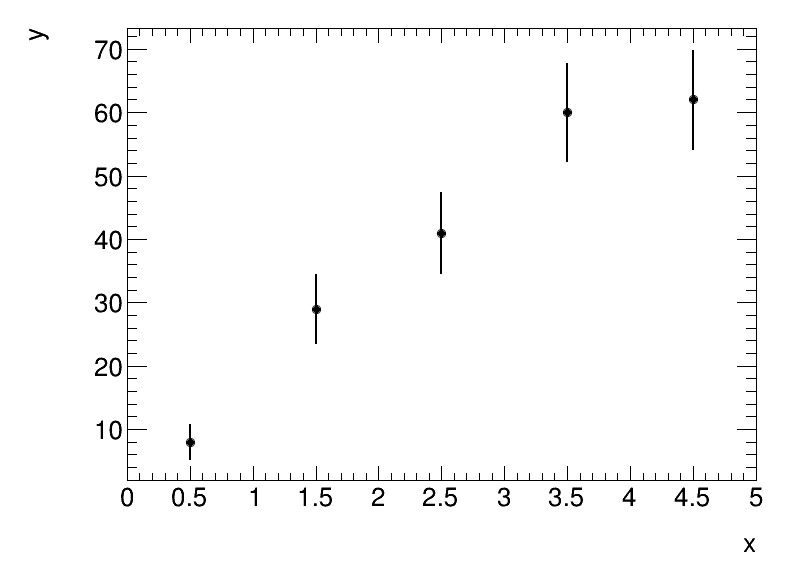

In [3]:
m = 11.
b = 2.5
bin0, bin1=0, 5
nbins = bin1-bin0

fl = R.TF1("flinear", "pol1", bin0, bin1)
fl.SetParameters(0, b)
fl.SetParameters(1, m)

hname = "test_data"
hd = R.TH1F(hname, hname, nbins, bin0, bin1)
hd.Sumw2()
hd.GetXaxis().SetTitle("x")
hd.GetYaxis().SetTitle("y")
hd.FillRandom("flinear", 200) 

myc = R.TCanvas("c", "c", 800, 600)
myc.SetFillColor(0)

myc.cd()
hd.Draw()
myc.Draw()

Do a fitting. By default ROOT uses Chi-square fit


****************************************
Minimizer is Linear / Migrad
Chi2                      =      2.43795
NDf                       =            3
p0                        =      1.71809   +/-   3.1885      
p1                        =      15.1177   +/-   1.66766     

****************************************
Minimizer is Linear / Migrad
Chi2                      =      2.43795
NDf                       =            3
p0                        =      1.71809   +/-   3.1885      
p1                        =      15.1177   +/-   1.66766     

Covariance Matrix:

            	          p0          p1
p0          	      10.167     -3.9292
p1          	     -3.9292      2.7811

Correlation Matrix:

            	          p0          p1
p0          	           1    -0.73894
p1          	    -0.73894           1


Info in <TCanvas::Print>: png file test_fitting_1.png has been created


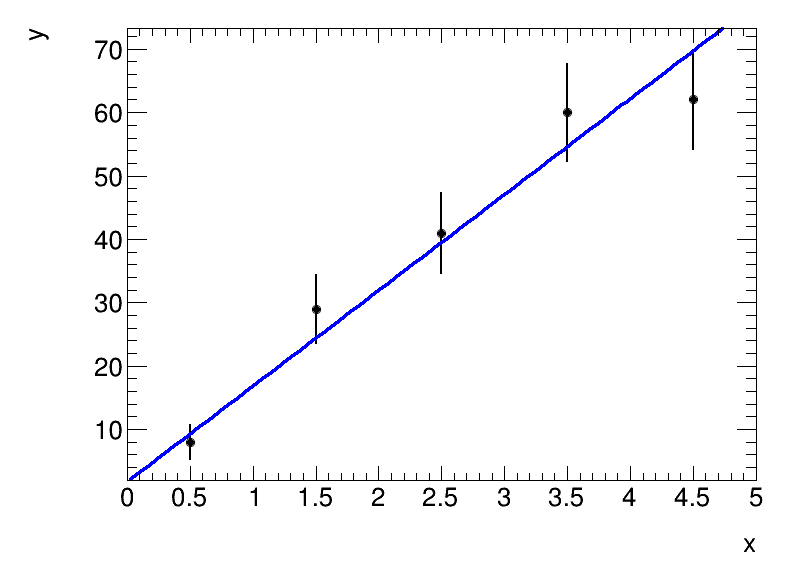

In [4]:
my1 = R.TF1("myFunc1", "pol1", bin0, bin1)
my1.SetLineColor(4)

frp1 = hd.Fit("myFunc1", "S")
frp1.Print("V")
myc.Update()
myc.Draw()
myc.SaveAs("test_fitting_1.png")

Do a linear regression BY HAND

In [5]:
l_x, l_y, l_ye=[], [], []
for i in range(1, nbins+1):
  l_x.append(hd.GetBinCenter(i))
  l_y.append(hd.GetBinContent(i))
  l_ye.append(hd.GetBinError(i))

[est_m, est_err_m, est_b, est_err_b, est_corr_mb] = lls(l_x, l_y, l_ye)
print("\nInput [x]:", l_x)
print("Input [y]:", l_y)
print("Input [y_err]:", l_ye)
print("Estimated m (p1): {0} +/- {1}".format(est_m, est_err_m))
print("Estimated b (p0): {0} +/- {1}".format(est_b, est_err_b))
print("Estimated correlation (m, b): {0}\n\n".format(est_corr_mb))

1.6676596448093777 1.6676596448093777 3.188503842606061 3.1885038426060603 -0.7389364642331806 -0.7389364642331806

Input [x]: [0.5, 1.5, 2.5, 3.5, 4.5]
Input [y]: [8.0, 29.0, 41.0, 60.0, 62.0]
Input [y_err]: [2.8284271247461903, 5.385164807134504, 6.4031242374328485, 7.745966692414834, 7.874007874011811]
Estimated m (p1): 15.117729551767999 +/- 1.6676596448093777
Estimated b (p0): 1.7180860595587057 +/- 3.1885038426060603
Estimated correlation (m, b): -0.7389364642331806




Now do a likelihood fit

 FCN=1.21602 FROM MIGRAD    STATUS=CONVERGED     157 CALLS         158 TOTAL
                     EDM=4.672e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.93421e+00   3.65636e+00   2.06054e-03  -2.05085e-06
   2  p1           1.52263e+01   1.81514e+00   1.02238e-03  -4.08006e-05
                               ERR DEF= 0.5


Info in <TCanvas::Print>: png file test_fitting_2.png has been created


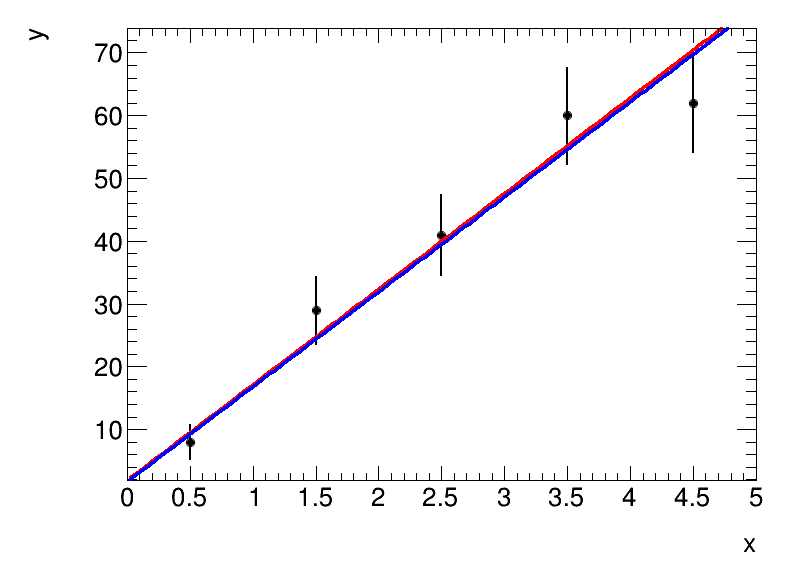

In [6]:
my2 = R.TF1("myFunc2", "pol1", bin0, bin1)
my2.SetLineColor(2)
frp2 = hd.Fit("myFunc2", "LS")
my1.Draw("same")
myc.Update()
myc.Draw()
myc.SaveAs("test_fitting_2.png")

Plot the NLL scan


****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      1.21602
Chi2                      =      2.47176
NDf                       =            3
Edm                       =    4.672e-09
NCalls                    =          158
p0                        =      1.93421   +/-   3.65636     
p1                        =      15.2263   +/-   1.81514     

Covariance Matrix:

            	          p0          p1
p0          	      13.369     -5.1922
p1          	     -5.1922      3.2947

Correlation Matrix:

            	          p0          p1
p0          	           1    -0.78233
p1          	    -0.78233           1

****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      1.21602
Chi2                      =      2.47176
NDf                       =            3
Edm                       =    4.672e-09
NCalls                    =          158
p0                        =      1.93421   +/-   3.65

Info in <TCanvas::Print>: png file test_fitting_3.png has been created


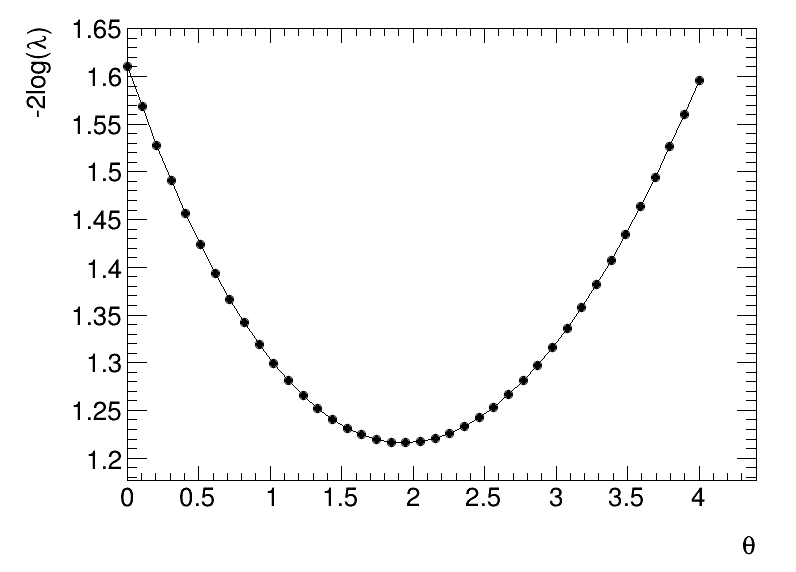

In [7]:
myc.Clear()
frp2.Print("V")
gr=R.TGraph()
smin, smax=0, 4
fr2=R.TFitResult(frp2.Get())
fr2.Print()
fr2.Scan(0, gr, smin, smax)
gr.Draw()
gr.GetXaxis().SetTitle("#theta")
gr.GetYaxis().SetTitle("-2log(#lambda)")
myc.Draw()

myc.SaveAs("test_fitting_3.png")

Draw all canvases 

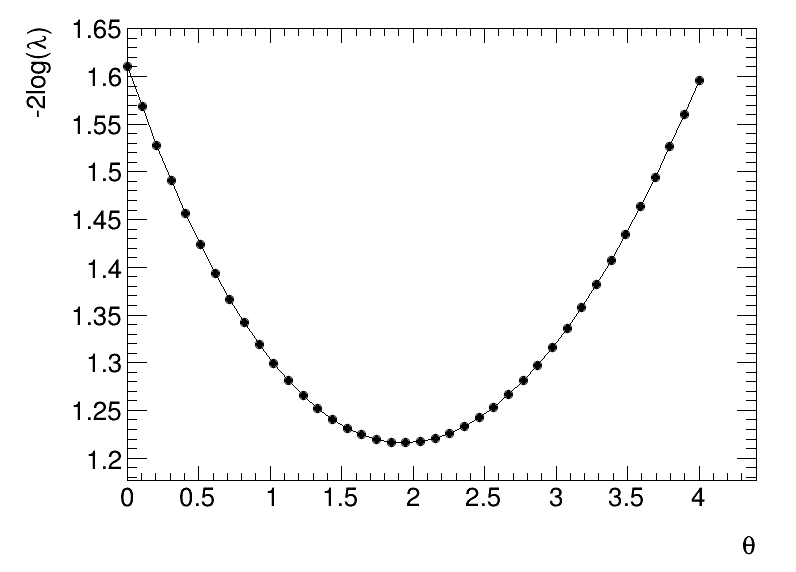

In [8]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()